# 11. 扩展卡尔曼滤波器

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

我们已经发展了线性卡尔曼滤波器的理论。然后，在最后两章中，我们涉及了使用卡尔曼滤波器处理非线性问题的话题。在这一章中，我们将学习扩展卡尔曼滤波器（EKF）。EKF通过在线性化当前估计点处的系统来处理非线性，然后使用线性卡尔曼滤波器来过滤这个线性化系统。它是最早用于非线性问题的技术之一，并且仍然是最常见的技术。

EKF给滤波器设计者带来了重大的数学挑战；这是本书中最具挑战性的一章。我尽一切可能避免使用EKF，而倾向于其他已经开发出来用于处理非线性问题的技术。然而，这个话题是不可避免的；所有经典论文和现今领域中大部分论文都使用EKF。即使你在自己的工作中不使用EKF，你也需要熟悉这个话题才能阅读相关文献。

# 线性化卡尔曼滤波器

卡尔曼滤波器使用线性方程，所以它无法处理非线性问题。问题可能以两种方式呈现非线性。首先，过程模型可能是非线性的。物体在大气中自由落体时会遇到减小其加速度的阻力。阻力系数根据物体的速度而变化。由此产生的行为是非线性的 - 无法用线性方程来建模。其次，测量可能是非线性的。例如，雷达给出目标的距离和方位角。我们使用三角函数，它是非线性的，来计算目标的位置。

对于线性滤波器，我们有以下过程和测量模型的方程：

$$\begin{aligned}\dot{\mathbf x} &= \mathbf{Ax} + w_x\\
\mathbf z &= \mathbf{Hx} + w_z
\end{aligned}$$

其中 $\mathbf A$ 是系统的动态矩阵。利用**卡尔曼滤波器数学**章节中介绍的状态空间方法，这些方程可以转换为

$$\begin{aligned}\bar{\mathbf x} &= \mathbf{Fx} \\
\mathbf z &= \mathbf{Hx}
\end{aligned}$$

这里 $\mathbf F$ 是*基本矩阵*。噪声 $w_x$ 和 $w_z$ 项被整合到矩阵 $\mathbf R$ 和 $\mathbf Q$ 中。这种形式的方程使我们能够根据步骤 $k$ 的测量和步骤 $k-1$ 的状态估计来计算步骤 $k$ 的状态。在之前的章节中，我通过使用能够用牛顿方程描述的问题来建立了你的直觉，并尽量减少了数学内容。我们知道如何根据高中物理来设计 $\mathbf F$。

对于非线性模型，线性表达式 $\mathbf{Fx} + \mathbf{Bu}$ 被非线性函数 $f(\mathbf x, \mathbf u)$ 替换，线性表达式 $\mathbf{Hx}$ 被非线性函数 $h(\mathbf x)$ 替换：

$$\begin{aligned}\dot{\mathbf x} &= f(\mathbf x, \mathbf u) + w_x\\
\mathbf z &= h(\mathbf x) + w_z
\end{aligned}$$

你可能想象我们可以通过找到一组新的卡尔曼滤波器方程来最优地解决这些方程。但是如果你记得**非线性滤波**章节中的图，你会记得通过非线性函数传递一个高斯分布将导致一个不再是高斯分布的概率分布。所以这种方法行不通。

扩展卡尔曼滤波器不改变卡尔曼滤波器的线性方程。相反，它在当前估计点*线性化*非线性方程，并在线性卡尔曼滤波器中使用这个线性化模型。

*线性化*就像它听起来的那样。我们找到一个在某一定义点最接近曲线的直线。下面的图表线性化了抛物线 $f(x)=x^2-2x$ 在 $x=1.5$ 处。

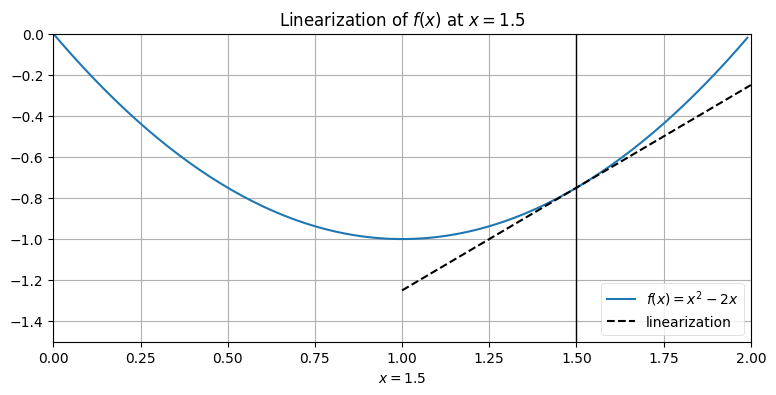

In [3]:
import kf_book.ekf_internal as ekf_internal
ekf_internal.show_linearization()

上面的曲线代表了过程模型，而虚线则显示了该曲线在估计值为 $x=1.5$ 处的线性化。

我们通过求导数来线性化系统，求导数可以找到曲线的斜率：

$$\begin{aligned}
f(x) &= x^2 -2x \\
\frac{df}{dx} &= 2x - 2
\end{aligned}$$

然后在 $x$ 处进行求值：

$$\begin{aligned}m &= f'(x=1.5) \\&= 2(1.5) - 2 \\&= 1\end{aligned}$$ 

线性化微分方程系统类似。我们通过对 $f(\mathbf x, \mathbf u)$ 和 $h(\mathbf x)$ 分别进行偏导数运算，在点 $\mathbf x_t$ 和 $\mathbf u_t$ 处评估 $\mathbf F$ 和 $\mathbf H$。我们称矩阵的偏导数为[*雅可比矩阵*](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)。这给了我们离散状态转移矩阵和测量模型矩阵：

$$
\begin{aligned}
\mathbf F 
&= {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\mathbf H &= \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t} 
\end{aligned}
$$

这导致了扩展卡尔曼滤波器的以下方程。我用方框标出了与线性滤波器不同的地方：

$$\begin{array}{l|l}
\text{KF} & \text{EKF} \\
\hline 
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$

在EKF中，我们通常不使用 $\mathbf{Fx}$ 来传播状态，因为线性化会导致不准确性。通常使用适当的数值积分技术，如欧拉法或Runge Kutta法来计算 $\bar{\mathbf x}$。因此我写成了 $\mathbf{\bar x} = f(\mathbf x, \mathbf u)$。出于同样的原因，我们在计算残差时也不使用 $\mathbf{H\bar{x}}$，而选择更精确的 $h(\bar{\mathbf x})$。

我认为理解EKF的最简单方法是从一个例子开始。之后你可能会想要回来重新阅读这一节。

# 示例：追踪飞机

这个例子是利用地面雷达追踪飞机。在上一章中，我们针对这个问题实现了一个UKF。现在我们将为同一个问题实现一个EKF，这样我们就可以比较滤波器的性能以及实现滤波器所需的工作量。

雷达工作原理是发射一束无线电波并搜索返回的信号。任何在波束路径上的物体都会将部分信号反射回雷达。通过计算反射信号返回雷达所需的时间，系统可以计算出*斜距* - 即雷达装置到物体之间的直线距离。

雷达的斜距距离 $r$ 和俯仰角 $\epsilon$ 与飞机的水平位置 $x$ 和高度 $y$ 之间的关系如下图所示：

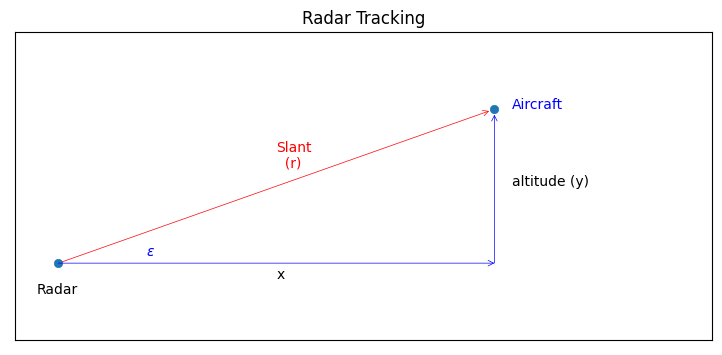

In [4]:
ekf_internal.show_radar_chart()

这给我们带来了以下的等式关系：

$$\begin{aligned}
\epsilon &= \tan^{-1} \frac y x\\
r^2 &= x^2 + y^2
\end{aligned}$$ 

# 设计状态变量

我们希望追踪飞机的位置，假设飞机的速度和高度保持不变，并且能够测量到飞机的斜距距离。这意味着我们需要三个状态变量 - 水平距离、水平速度和高度：

$$\mathbf x = \begin{bmatrix}\mathtt{距离} \\\mathtt{速度}\\ \mathtt{高度}\end{bmatrix}=    \begin{bmatrix}x \\ \dot x\\ y\end{bmatrix}$$

# 设计过程模型

我们假设飞机遵循牛顿运动学系统。在之前的章节中，我们使用过这个模型，所以你可能会发现我们想要的是：

$$\mathbf F = \left[\begin{array}{cc|c} 1 & \Delta t & 0\\
0 & 1 & 0 \\ \hline
0 & 0 & 1\end{array}\right]$$

我将矩阵分块以显示左上角块是 $x$ 的恒定速度模型，右下角块是 $y$ 的恒定位置模型。

然而，让我们练习一下如何找到这些矩阵。我们用一组微分方程来建模系统。我们需要一个形式为 

$$\dot{\mathbf x} = \mathbf{Ax} + \mathbf{w}$$
的方程，其中 $\mathbf{w}$ 是系统噪声。

$x$ 和 $y$ 是独立的，因此我们可以分别计算它们。在一维运动的微分方程是：

$$\begin{aligned}v &= \dot x \\
a &= \ddot{x} = 0\end{aligned}$$

现在我们将微分方程放入状态空间形式。如果这是一个二阶或更高阶的微分系统，我们首先必须将其化简为等效的一阶方程组。这些方程是一阶的，所以我们将它们放入状态空间矩阵形式中：

$$\begin{aligned}\begin{bmatrix}\dot x \\ \ddot{x}\end{bmatrix} &= \begin{bmatrix}0&1\\0&0\end{bmatrix} \begin{bmatrix}x \\ 
\dot x\end{bmatrix} \\ \dot{\mathbf x} &= \mathbf{Ax}\end{aligned}$$
其中 $\mathbf A=\begin{bmatrix}0&1\\0&0\end{bmatrix}$。 

回想一下，$\mathbf A$ 是*系统动态矩阵*。它描述了一组线性微分方程。从中，我们必须计算状态转移矩阵 $\mathbf F$。$\mathbf F$ 描述了一组离散的线性方程，用于计算在离散时间步长 $\Delta t$ 内的 $\mathbf x$。

计算 $\mathbf F$ 的一种常见方法是使用矩阵指数的幂级数展开：

$$\mathbf F(\Delta t) = e^{\mathbf A\Delta t} = \mathbf{I} + \mathbf A\Delta t  + \frac{(\mathbf A\Delta t)^2}{2!} + \frac{(\mathbf A \Delta t)^3}{3!} + ... $$


$\mathbf A^2 = \begin{bmatrix}0&0\\0&0\end{bmatrix}$，所以所有 $\mathbf A$ 的更高次幂也都是 $\mathbf{0}$。因此，幂级数展开为：

$$
\begin{aligned}
\mathbf F &=\mathbf{I} + \mathbf At + \mathbf{0} \\
&= \begin{bmatrix}1&0\\0&1\end{bmatrix} + \begin{bmatrix}0&1\\0&0\end{bmatrix}\Delta t\\
\mathbf F &= \begin{bmatrix}1&\Delta t\\0&1\end{bmatrix}
\end{aligned}$$

这和运动学方程使用的结果相同！这个练习其实是不必要的，只是为了说明如何从线性微分方程中找到状态转移矩阵。我们将在本章结束时用一个例子来总结这种技术的应用。

# 设计测量模型

设计测量模型时，测量函数将先前的先验状态估计 $\bar{\mathbf x}$ 转化为斜距距离的测量值。我们使用勾股定理推导出：

$$h(\bar{\mathbf x}) = \sqrt{x^2 + y^2}$$

由于平方根，斜距距离和地面位置之间的关系是非线性的。我们通过在 $\mathbf x_t$ 处评估其偏导数来将其线性化：

$$
\mathbf H = \frac{\partial{h(\bar{\mathbf x})}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}
$$

矩阵的偏导数称为雅可比矩阵，其形式为

$$\frac{\partial \mathbf H}{\partial \bar{\mathbf x}} = 
\begin{bmatrix}
\frac{\partial h_1}{\partial x_1} & \frac{\partial h_1}{\partial x_2} &\dots \\
\frac{\partial h_2}{\partial x_1} & \frac{\partial h_2}{\partial x_2} &\dots \\
\vdots & \vdots
\end{bmatrix}
$$

换句话说，矩阵中的每个元素都是函数 $h$ 关于 $x$ 变量的偏导数。对于我们的问题，我们有

$$\mathbf H = \begin{bmatrix}{\partial h}/{\partial x} & {\partial h}/{\partial \dot{x}} & {\partial h}/{\partial y}\end{bmatrix}$$

依次解决每个问题：

$$\begin{aligned}
\frac{\partial h}{\partial x} &= \frac{\partial}{\partial x} \sqrt{x^2 + y^2} \\
&= \frac{x}{\sqrt{x^2 + y^2}}
\end{aligned}$$

和

$$\begin{aligned}
\frac{\partial h}{\partial \dot{x}} &=
\frac{\partial}{\partial \dot{x}} \sqrt{x^2 + y^2} \\ 
&= 0
\end{aligned}$$

和

$$\begin{aligned}
\frac{\partial h}{\partial y} &= \frac{\partial}{\partial y} \sqrt{x^2 + y^2} \\ 
&= \frac{y}{\sqrt{x^2 + y^2}}
\end{aligned}$$

得到

$$\mathbf H = 
\begin{bmatrix}
\frac{x}{\sqrt{x^2 + y^2}} & 
0 &
&
\frac{y}{\sqrt{x^2 + y^2}}
\end{bmatrix}$$

这可能看起来令人生畏，但退一步想想，所有这些数学都在做一件非常简单的事情。我们有一个非线性的飞机斜距方程。卡尔曼滤波器只能处理线性方程，因此我们需要找到一个线性方程来近似 $\mathbf H$。如上所述，找到给定点处非线性方程的斜率是一个很好的近似。对于卡尔曼滤波器，‘给定点’是状态变量 $\mathbf x$，因此我们需要对斜距进行关于 $\mathbf x$ 的导数计算。对于线性卡尔曼滤波器，$\mathbf H$ 是一个先前在运行滤波器之前计算的常数。对于EKF，$\mathbf H$ 在每个步骤中都会更新，因为评估点 $\bar{\mathbf x}$ 在每个时刻都在变化。

为了更具体，现在让我们编写一个Python函数，计算这个问题的 $h$ 的雅可比矩阵。

In [5]:
from math import sqrt
def HJacobian_at(x):
    """ compute Jacobian of H matrix at x """

    horiz_dist = x[0]
    altitude   = x[2]
    denom = sqrt(horiz_dist**2 + altitude**2)
    return array ([[horiz_dist/denom, 0., altitude/denom]])

以下是计算这个问题中测量函数$h(\bar{\mathbf x})$的代码示例：

In [6]:
def hx(x):
    """ compute measurement for slant range that
    would correspond to state x.
    """
    
    return (x[0]**2 + x[2]**2) ** 0.5

现在让我们为雷达编写一个模拟。

In [7]:
from numpy.random import randn
import math

class RadarSim:
    """ Simulates the radar signal returns from an object
    flying at a constant altityude and velocity in 1D. 
    """
    
    def __init__(self, dt, pos, vel, alt):
        self.pos = pos
        self.vel = vel
        self.alt = alt
        self.dt = dt
        
    def get_range(self):
        """ Returns slant range to the object. Call once 
        for each new measurement at dt time from last call.
        """
        
        # add some process noise to the system
        self.vel = self.vel  + .1*randn()
        self.alt = self.alt + .1*randn()
        self.pos = self.pos + self.vel*self.dt
    
        # add measurement noise
        err = self.pos * 0.05*randn()
        slant_dist = math.sqrt(self.pos**2 + self.alt**2)
        
        return slant_dist + err

雷达测量目标的距离。我们将噪声设为$\sigma_{range}= 5$米。这给了我们

$$\mathbf R = \begin{bmatrix}\sigma_{range}^2\end{bmatrix} = \begin{bmatrix}25\end{bmatrix}$$


$\mathbf Q$的设计需要一些讨论。状态$\mathbf x= \begin{bmatrix}x & \dot x & y\end{bmatrix}^\mathtt{T}$。前两个元素是位置（沿着距离方向的距离）和速度，因此我们可以使用`Q_discrete_white_noise`噪声来计算$\mathbf Q$左上方的值。$\mathbf x$的第三个元素是高度，我们假设它与距离独立。这导致了$\mathbf Q$的分块设计如下：

$$\mathbf Q = \begin{bmatrix}\mathbf Q_\mathtt{x} & 0 \\ 0 & \mathbf Q_\mathtt{y}\end{bmatrix}$$


# 实现

`FilterPy`提供了`ExtendedKalmanFilter`类。它的工作方式与我们之前使用的`KalmanFilter`类类似，不同之处在于它允许您提供一个计算$\mathbf H$的雅可比矩阵和函数$h(\mathbf x)$的函数。

首先，我们导入滤波器并创建它。`x`的维度是3，`z`的维度是1。

```python
from filterpy.kalman import ExtendedKalmanFilter

rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
```
然后，我们创建雷达模拟器：

```python
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)
```
我们将在飞机实际位置附近初始化滤波器：

```python
rk.x = array([radar.pos, radar.vel-10, radar.alt+100])
```

我们使用上面计算的泰勒级数展开的第一项来赋值系统矩阵：

```python
dt = 0.05
rk.F = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]])*dt
```

在为$\mathbf R$、$\mathbf Q$和$\mathbf P$分配合理的值之后，我们可以通过一个简单的循环来运行滤波器。我们将计算$\mathbf H$的雅可比矩阵和$h(\mathbf x)$的函数传递给`update`方法。

```python
for i in range(int(20/dt)):
    z = radar.get_range()
    rk.update(array([z]), HJacobian_at, hx)
    rk.predict()
```

为了保存和绘制结果，我们添加一些样板代码。

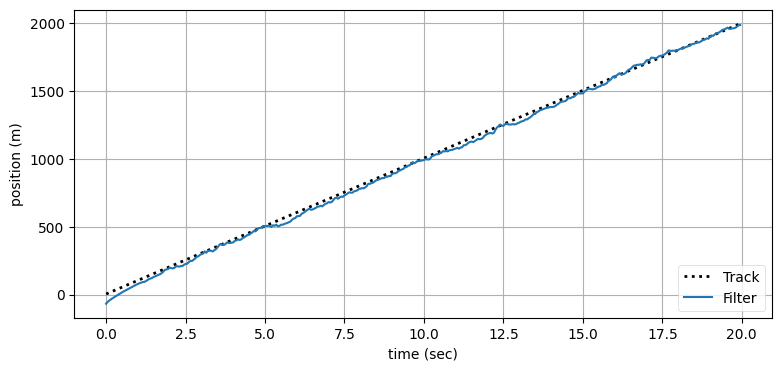

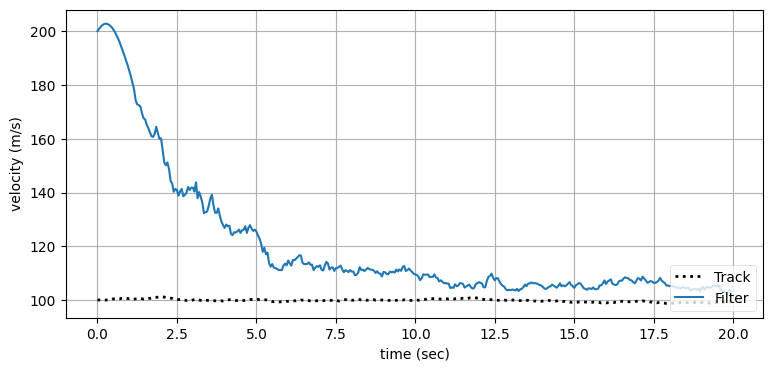

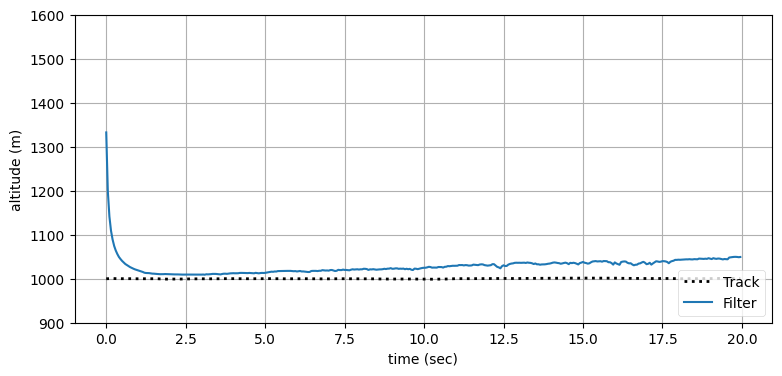

In [8]:
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import ExtendedKalmanFilter
from numpy import eye, array, asarray
import numpy as np

dt = 0.05
rk = ExtendedKalmanFilter(dim_x=3, dim_z=1)
radar = RadarSim(dt, pos=0., vel=100., alt=1000.)

# make an imperfect starting guess
rk.x = array([radar.pos-100, radar.vel+100, radar.alt+1000])

rk.F = eye(3) + array([[0, 1, 0],
                       [0, 0, 0],
                       [0, 0, 0]]) * dt

range_std = 5. # meters
rk.R = np.diag([range_std**2])
rk.Q[0:2, 0:2] = Q_discrete_white_noise(2, dt=dt, var=0.1)
rk.Q[2,2] = 0.1
rk.P *= 50

xs, track = [], []
for i in range(int(20/dt)):
    z = radar.get_range()
    track.append((radar.pos, radar.vel, radar.alt))
    
    rk.update(array([z]), HJacobian_at, hx)
    xs.append(rk.x)
    rk.predict()

xs = asarray(xs)
track = asarray(track)
time = np.arange(0, len(xs)*dt, dt)
ekf_internal.plot_radar(xs, track, time)

# 使用 SymPy 计算雅可比行列式

根据你对导数的经验，计算雅可比矩阵可能会觉得困难。即使你觉得这很容易，稍微复杂一点的问题很容易导致计算变得非常困难。

正如附录A中所解释的，我们可以使用SymPy包来为我们计算雅可比矩阵。

In [9]:
import sympy
from IPython.display import display
sympy.init_printing(use_latex='mathjax')

x, x_vel, y = sympy.symbols('x, x_vel y')

H = sympy.Matrix([sympy.sqrt(x**2 + y**2)])

state = sympy.Matrix([x, x_vel, y])
J = H.jacobian(state)

display(state)
display(J)

⎡ x  ⎤
⎢    ⎥
⎢xᵥₑₗ⎥
⎢    ⎥
⎣ y  ⎦

⎡     x                y      ⎤
⎢────────────  0  ────────────⎥
⎢   _________        _________⎥
⎢  ╱  2    2        ╱  2    2 ⎥
⎣╲╱  x  + y       ╲╱  x  + y  ⎦

这个结果与我们之前计算的结果相同，而我们的付出要少得多！

# 机器人定位

现在是尝试一个真实问题的时候了。我要提醒你，这部分内容可能会有些困难。大多数书籍选择简单的、教科书式的问题，得到简单的答案，而你可能会想知道如何解决真实世界的问题。

我们将考虑机器人定位的问题。我们已经在**无迹卡尔曼滤波**章节中实现了这一点，如果你还没有阅读过，我建议你现在去看一下。在这个场景中，我们有一个机器人通过传感器在景观中移动，并检测地标。这可能是一辆使用计算机视觉识别树木、建筑物和其他地标的自动驾驶汽车。它可能是那种清扫你家的小型吸尘器机器人，或者是仓库中的机器人。

这个机器人有4个轮子，布局与汽车相同。它通过转动前轮来操纵。这导致机器人围绕后轮轴旋转，同时向前移动。这是一种非线性行为，我们需要对其建模。

机器人有一个传感器，用于测量景观中已知目标的距离和方位角。这是非线性的，因为根据距离和方位角计算位置需要使用平方根和三角函数。

这两种模型——过程模型和测量模型——都是非线性的。扩展卡尔曼滤波适应了这两种模型，因此我们暂时得出结论，扩展卡尔曼滤波对于解决这个问题是可行的选择。

# 机器人移动模型

在初步近似中，汽车在前进时通过转动前轮来转向。汽车的前部朝着轮子指向的方向移动，同时围绕后轮转动。然而，这个简单的描述被一些问题复杂化了，比如因摩擦而产生的打滑、不同速度下橡胶轮胎的不同行为，以及外侧轮胎需要行驶不同半径的问题。准确建模转向需要一系列复杂的微分方程。

对于低速机器人应用，人们发现了一个更简单的*自行车模型*能够表现良好。这是该模型的描述：

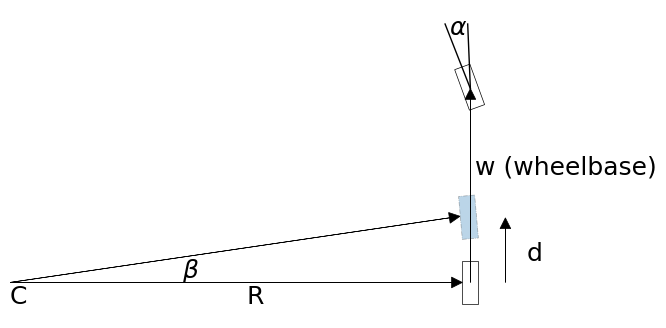

In [10]:
ekf_internal.plot_bicycle()

在**无迹卡尔曼滤波**章节中，我们推导出了这些方程：

$$\begin{aligned} 
\beta &= \frac d w \tan(\alpha) \\
x &= x - R\sin(\theta) + R\sin(\theta + \beta) \\
y &= y + R\cos(\theta) - R\cos(\theta + \beta) \\
\theta &= \theta + \beta
\end{aligned}
$$

其中，$\theta$是机器人的航向角。

如果你对转向模型不感兴趣，就不需要详细了解这个模型。需要注意的重要一点是，我们的运动模型是非线性的，我们需要用卡尔曼滤波器来处理这个问题。

# 设计状态变量

我们的滤波器将维护机器人的位置 $x,y$ 和方向 $\theta$：

$$\mathbf x = \begin{bmatrix}x \\ y \\ \theta\end{bmatrix}$$

我们的控制输入 $\mathbf u$ 是速度 $v$ 和转向角 $\alpha$：

$$\mathbf u = \begin{bmatrix}v \\ \alpha\end{bmatrix}$$

# 设计过程模型

我们将我们的系统建模为非线性运动模型加上噪声。

$$\bar x = f(x, u) + \mathcal{N}(0, Q)$$

利用我们上面创建的机器人运动模型，我们可以将其展开为：

$$\bar{\begin{bmatrix}x\\y\\\theta\end{bmatrix}} = \begin{bmatrix}x\\y\\\theta\end{bmatrix} + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}$$

我们通过对$f(x,u)$的雅可比矩阵进行计算，得到 $\mathbf F$。

$$\mathbf F = \frac{\partial f(x, u)}{\partial x} =\begin{bmatrix}
\frac{\partial f_1}{\partial x} & 
\frac{\partial f_1}{\partial y} &
\frac{\partial f_1}{\partial \theta}\\
\frac{\partial f_2}{\partial x} & 
\frac{\partial f_2}{\partial y} &
\frac{\partial f_2}{\partial \theta} \\
\frac{\partial f_3}{\partial x} & 
\frac{\partial f_3}{\partial y} &
\frac{\partial f_3}{\partial \theta}
\end{bmatrix}
$$

计算这些项后，我们得到：

$$\mathbf F = \begin{bmatrix}
1 & 0 & -R\cos(\theta) + R\cos(\theta+\beta) \\
0 & 1 & -R\sin(\theta) + R\sin(\theta+\beta) \\
0 & 0 & 1
\end{bmatrix}$$

我们可以用SymPy来检查我们的计算结果。

In [14]:
import sympy
from sympy.abc import alpha, x, y, v, w, R, theta
from sympy import symbols, Matrix
sympy.init_printing(use_latex="mathjax", fontsize='16pt')
time = symbols('t')
d = v*time
beta = (d/w)*sympy.tan(alpha)
r = w/sympy.tan(alpha)

fxu = Matrix([[x-r*sympy.sin(theta) + r*sympy.sin(theta+beta)],
              [y+r*sympy.cos(theta)- r*sympy.cos(theta+beta)],
              [theta+beta]])
F = fxu.jacobian(Matrix([x, y, theta]))
F

⎡                        ⎛t⋅v⋅tan(α)    ⎞⎤
⎢                   w⋅cos⎜────────── + θ⎟⎥
⎢        w⋅cos(θ)        ⎝    w         ⎠⎥
⎢1  0  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎢                        ⎛t⋅v⋅tan(α)    ⎞⎥
⎢                   w⋅sin⎜────────── + θ⎟⎥
⎢        w⋅sin(θ)        ⎝    w         ⎠⎥
⎢0  1  - ──────── + ─────────────────────⎥
⎢         tan(α)            tan(α)       ⎥
⎢                                        ⎥
⎣0  0                  1                 ⎦

看起来有点复杂。我们可以使用SymPy来替换项：

In [15]:
B, R = symbols('beta, R')
F = F.subs((d/w)*sympy.tan(alpha), B)
F.subs(w/sympy.tan(alpha), R)

⎡1  0  -R⋅cos(θ) + R⋅cos(β + θ)⎤
⎢                              ⎥
⎢0  1  -R⋅sin(θ) + R⋅sin(β + θ)⎥
⎢                              ⎥
⎣0  0             1            ⎦

这种形式验证了雅可比矩阵的计算是正确的。

现在我们可以把注意力转向噪声。在这里，噪声存在于我们的控制输入中，因此它在*控制空间*中。换句话说，我们指定一个特定的速度和转向角，但我们需要将其转换为 $x, y, \theta$ 中的误差。在一个真实的系统中，这可能会根据速度而变化，因此需要为每次预测重新计算。我会选择这个作为噪声模型；对于一个真实的机器人，你需要选择一个准确描述系统误差的模型。

$$\mathbf{M} = \begin{bmatrix}\sigma_{vel}^2 & 0 \\ 0 & \sigma_\alpha^2\end{bmatrix}$$

如果这是一个线性问题，我们会使用现在已经熟悉的 $\mathbf{FMF}^\mathsf T$ 形式来将控制空间转换为状态空间。由于我们的运动模型是非线性的，我们不尝试找到这个的封闭形式解，而是用一个雅可比矩阵线性化它，我们将其命名为 $\mathbf{V}$。

$$\mathbf{V} = \frac{\partial f(x, u)}{\partial u} \begin{bmatrix}
\frac{\partial f_1}{\partial v} & \frac{\partial f_1}{\partial \alpha} \\
\frac{\partial f_2}{\partial v} & \frac{\partial f_2}{\partial \alpha} \\
\frac{\partial f_3}{\partial v} & \frac{\partial f_3}{\partial \alpha}
\end{bmatrix}$$

这些偏导数变得非常难处理。让我们用SymPy来计算它们。

In [16]:
V = fxu.jacobian(Matrix([v, alpha]))
V = V.subs(sympy.tan(alpha)/w, 1/R) 
V = V.subs(time*v/R, B)
V = V.subs(time*v, 'd')
V

⎡                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅cos(β + θ)   w⋅⎝- tan (α) - 1⎠⋅sin(θ)   w⋅⎝- ta
⎢t⋅cos(β + θ)  ────────────────────────── - ──────────────────────── + ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                ⎛   2       ⎞                ⎛     2       ⎞            ⎛    
⎢              d⋅⎝tan (α) + 1⎠⋅sin(β + θ)   w⋅⎝- tan (α) - 1⎠⋅cos(θ)   w⋅⎝- ta
⎢t⋅sin(β + θ)  ────────────────────────── + ──────────────────────── - ───────
⎢                        tan(α)                        2                      
⎢                                                   tan (α)                   
⎢                                                                             
⎢                                                  ⎛

这会让你更加意识到扩展卡尔曼滤波在数学上变得多么难以处理。

这给了我们预测方程的最终形式：

$$\begin{aligned}
\mathbf{\bar x} &= \mathbf x + 
\begin{bmatrix}- R\sin(\theta) + R\sin(\theta + \beta) \\
R\cos(\theta) - R\cos(\theta + \beta) \\
\beta\end{bmatrix}\\
\mathbf{\bar P} &=\mathbf{FPF}^{\mathsf T} + \mathbf{VMV}^{\mathsf T}
\end{aligned}$$

这种线性化的形式并不是预测 $\mathbf x$ 的唯一方式。例如，我们可以使用数值积分技术，比如 *Runge Kutta* 来计算机器人的运动。如果时间步长相对较大，这将是必需的。对于 EKF，并不像对于卡尔曼滤波器那样一刀切。对于一个真实的问题，你必须仔细地用微分方程对系统进行建模，然后确定解决该系统的最合适的方法。正确的方法取决于你所需的精度、方程的非线性程度、你的处理器预算和数值稳定性方面的考虑。

# 设计测量模型

测量模型必须将状态 $\begin{bmatrix}x & y&\theta\end{bmatrix}^\mathsf T$ 转换为对地标的距离和方位角，机器人的传感器提供了到景观中多个已知位置的带有噪声的方位角和距离测量值。如果 $\mathbf p$ 是地标的位置，那么距离 $r$ 是

$$r = \sqrt{(p_x - x)^2 + (p_y - y)^2}$$

传感器提供的方位角是相对于机器人方向的，因此我们必须从方位角中减去机器人的方向以获取传感器读数，如下所示：

$$\phi = \arctan(\frac{p_y - y}{p_x - x}) - \theta$$

因此，我们的测量模型 $h$ 是

$$\begin{aligned}
\mathbf z& = h(\bar{\mathbf x}, \mathbf p) &+ \mathcal{N}(0, R)\\
&= \begin{bmatrix}
\sqrt{(p_x - x)^2 + (p_y - y)^2} \\
\arctan(\frac{p_y - y}{p_x - x}) - \theta 
\end{bmatrix} &+ \mathcal{N}(0, R)
\end{aligned}$$

这显然是非线性的，所以我们需要在 $\mathbf x$ 处对 $h$ 进行线性化，通过取其雅可比矩阵来计算。我们将使用SymPy来计算这一步。

In [17]:
px, py = symbols('p_x, p_y')
z = Matrix([[sympy.sqrt((px-x)**2 + (py-y)**2)],
            [sympy.atan2(py-y, px-x) - theta]])
z.jacobian(Matrix([x, y, theta]))

⎡          -pₓ + x                      -p_y + y             ⎤
⎢───────────────────────────  ───────────────────────────  0 ⎥
⎢   ________________________     ________________________    ⎥
⎢  ╱         2            2     ╱         2            2     ⎥
⎢╲╱  (pₓ - x)  + (p_y - y)    ╲╱  (pₓ - x)  + (p_y - y)      ⎥
⎢                                                            ⎥
⎢       -(-p_y + y)                   -(pₓ - x)              ⎥
⎢  ──────────────────────       ──────────────────────     -1⎥
⎢          2            2               2            2       ⎥
⎣  (pₓ - x)  + (p_y - y)        (pₓ - x)  + (p_y - y)        ⎦

现在我们需要将其编写为 Python 函数。 例如我们可以这样写：

In [18]:
from math import sqrt

def H_of(x, landmark_pos):
    """ compute Jacobian of H matrix where h(x) computes 
    the range and bearing to a landmark for state x """

    px = landmark_pos[0]
    py = landmark_pos[1]
    hyp = (px - x[0, 0])**2 + (py - x[1, 0])**2
    dist = sqrt(hyp)

    H = array(
        [[-(px - x[0, 0]) / dist, -(py - x[1, 0]) / dist, 0],
         [ (py - x[1, 0]) / hyp,  -(px - x[0, 0]) / hyp, -1]])
    return H

我们还需要定义一个将系统状态转换为测量值的函数。

In [19]:
from math import atan2

def Hx(x, landmark_pos):
    """ takes a state variable and returns the measurement
    that would correspond to that state.
    """
    px = landmark_pos[0]
    py = landmark_pos[1]
    dist = sqrt((px - x[0, 0])**2 + (py - x[1, 0])**2)

    Hx = array([[dist],
                [atan2(py - x[1, 0], px - x[0, 0]) - x[2, 0]]])
    return Hx

# 设计测量噪声

假设距离和方位角测量的噪声是独立的是合理的，因此

$$\mathbf R=\begin{bmatrix}\sigma_{range}^2 & 0 \\ 0 & \sigma_{bearing}^2\end{bmatrix}$$

# 实现

我们将使用 `FilterPy` 中的 `ExtendedKalmanFilter` 类来实现滤波器。它的 `predict()` 方法使用了标准的线性方程来建立模型。然而我们的模型是非线性的，所以我们需要用自己的方法来重写 `predict()`。我还想用这个类来模拟机器人，所以我会添加一个名为 `move()` 的方法来计算机器人的位置，这样 `predict()` 和我的模拟都可以调用。

预测步骤中的矩阵相当庞大。在编写这段代码时，我出了好几次错才最终让它正常运行。我只有通过使用 SymPy 的 `evalf` 函数才发现了错误。`evalf` 可以使用特定变量值对 SymPy 的 `Matrix` 进行求值。我决定向你展示这个技巧，并在卡尔曼滤波器代码中使用了 `evalf`。你需要了解几点。

首先，`evalf` 使用字典来指定数值。例如，如果你的矩阵包含 `x` 和 `y`，你可以这样写：

```python
    M.evalf(subs={x:3, y:17})
```

来计算 `x=3`，`y=17` 时的矩阵值。

其次，`evalf` 返回一个 `sympy.Matrix` 对象。使用 `numpy.array(M).astype(float)` 将其转换为 NumPy 数组。`numpy.array(M)` 创建的是一个 `object` 类型的数组，这不是你想要的。

这是 EKF 的代码：

In [20]:
from filterpy.kalman import ExtendedKalmanFilter as EKF
from numpy import array, sqrt
class RobotEKF(EKF):
    def __init__(self, dt, wheelbase, std_vel, std_steer):
        EKF.__init__(self, 3, 2, 2)
        self.dt = dt
        self.wheelbase = wheelbase
        self.std_vel = std_vel
        self.std_steer = std_steer

        a, x, y, v, w, theta, time = symbols(
            'a, x, y, v, w, theta, t')
        d = v*time
        beta = (d/w)*sympy.tan(a)
        r = w/sympy.tan(a)
    
        self.fxu = Matrix(
            [[x-r*sympy.sin(theta)+r*sympy.sin(theta+beta)],
             [y+r*sympy.cos(theta)-r*sympy.cos(theta+beta)],
             [theta+beta]])

        self.F_j = self.fxu.jacobian(Matrix([x, y, theta]))
        self.V_j = self.fxu.jacobian(Matrix([v, a]))

        # save dictionary and it's variables for later use
        self.subs = {x: 0, y: 0, v:0, a:0, 
                     time:dt, w:wheelbase, theta:0}
        self.x_x, self.x_y, = x, y 
        self.v, self.a, self.theta = v, a, theta

    def predict(self, u):
        self.x = self.move(self.x, u, self.dt)
        self.subs[self.x_x] = self.x[0, 0]
        self.subs[self.x_y] = self.x[1, 0]

        self.subs[self.theta] = self.x[2, 0]
        self.subs[self.v] = u[0]
        self.subs[self.a] = u[1]

        F = array(self.F_j.evalf(subs=self.subs)).astype(float)
        V = array(self.V_j.evalf(subs=self.subs)).astype(float)

        # covariance of motion noise in control space
        M = array([[self.std_vel**2, 0], 
                   [0, self.std_steer**2]])

        self.P = F @ self.P @ F.T + V @ M @ V.T

    def move(self, x, u, dt):
        hdg = x[2, 0]
        vel = u[0]
        steering_angle = u[1]
        dist = vel * dt

        if abs(steering_angle) > 0.001: # is robot turning?
            beta = (dist / self.wheelbase) * tan(steering_angle)
            r = self.wheelbase / tan(steering_angle) # radius

            dx = np.array([[-r*sin(hdg) + r*sin(hdg + beta)], 
                           [r*cos(hdg) - r*cos(hdg + beta)], 
                           [beta]])
        else: # moving in straight line
            dx = np.array([[dist*cos(hdg)], 
                           [dist*sin(hdg)], 
                           [0]])
        return x + dx

现在我们有另一个问题要处理。残差通常计算为 $y = z - h(x)$，但这种方法行不通，因为我们的测量中包含一个角度。假设 z 的方位角是 $1^\circ$，而 $h(x)$ 的方位角是 $359^\circ$。简单地相减会得到一个角度差为 $-358^\circ$，而正确的值应该是 $2^\circ$。我们需要编写代码来正确计算方位角的残差。

In [21]:
def residual(a, b):
    """ compute residual (a-b) between measurements containing 
    [range, bearing]. Bearing is normalized to [-pi, pi)"""
    y = a - b
    y[1] = y[1] % (2 * np.pi)    # force in range [0, 2 pi)
    if y[1] > np.pi:             # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y

代码的其余部分运行模拟并绘制结果，现在应该不需要太多注释了。我创建了一个变量 `landmarks` 来存储地标坐标。我以每秒 10 次的频率更新模拟机器人的位置，但每秒只运行一次 EKF。这有两个原因。首先，我们没有使用龙格-库塔（Runge Kutta）来积分运动微分方程，所以较小的时间步长可以让我们的模拟更准确。其次，在嵌入式系统中，处理速度通常有限。这迫使你只在绝对必要时才以频繁的频率运行卡尔曼滤波器。

In [22]:
from filterpy.stats import plot_covariance_ellipse
from math import sqrt, tan, cos, sin, atan2
import matplotlib.pyplot as plt

dt = 1.0

def z_landmark(lmark, sim_pos, std_rng, std_brg):
    x, y = sim_pos[0, 0], sim_pos[1, 0]
    d = np.sqrt((lmark[0] - x)**2 + (lmark[1] - y)**2)  
    a = atan2(lmark[1] - y, lmark[0] - x) - sim_pos[2, 0]
    z = np.array([[d + randn()*std_rng],
                  [a + randn()*std_brg]])
    return z

def ekf_update(ekf, z, landmark):
    ekf.update(z, HJacobian=H_of, Hx=Hx, 
               residual=residual,
               args=(landmark), hx_args=(landmark))
    
                
def run_localization(landmarks, std_vel, std_steer, 
                     std_range, std_bearing,
                     step=10, ellipse_step=20, ylim=None):
    ekf = RobotEKF(dt, wheelbase=0.5, std_vel=std_vel, 
                   std_steer=std_steer)
    ekf.x = array([[2, 6, .3]]).T # x, y, steer angle
    ekf.P = np.diag([.1, .1, .1])
    ekf.R = np.diag([std_range**2, std_bearing**2])

    sim_pos = ekf.x.copy() # simulated position
    # steering command (vel, steering angle radians)
    u = array([1.1, .01]) 

    plt.figure()
    plt.scatter(landmarks[:, 0], landmarks[:, 1],
                marker='s', s=60)
    
    track = []
    for i in range(200):
        sim_pos = ekf.move(sim_pos, u, dt/10.) # simulate robot
        track.append(sim_pos)

        if i % step == 0:
            ekf.predict(u=u)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2], 
                     std=6, facecolor='k', alpha=0.3)

            x, y = sim_pos[0, 0], sim_pos[1, 0]
            for lmark in landmarks:
                z = z_landmark(lmark, sim_pos,
                               std_range, std_bearing)
                ekf_update(ekf, z, lmark)

            if i % ellipse_step == 0:
                plot_covariance_ellipse(
                    (ekf.x[0,0], ekf.x[1,0]), ekf.P[0:2, 0:2],
                    std=6, facecolor='g', alpha=0.8)
    track = np.array(track)
    plt.plot(track[:, 0], track[:,1], color='k', lw=2)
    plt.axis('equal')
    plt.title("EKF Robot localization")
    if ylim is not None: plt.ylim(*ylim)
    plt.show()
    return ekf

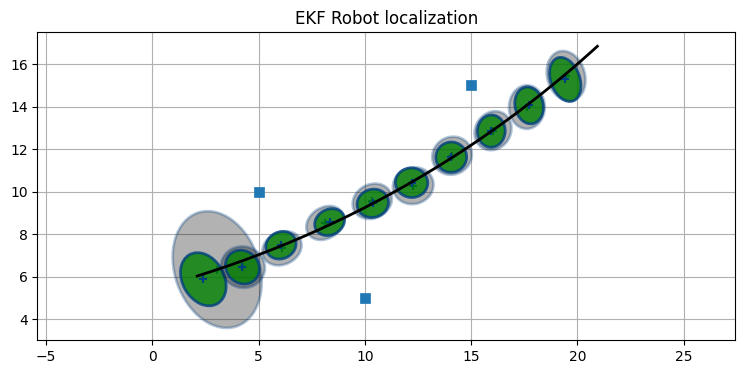

Final P: [0.017 0.035 0.002]


In [23]:
landmarks = array([[5, 10], [10, 5], [15, 15]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
print('Final P:', ekf.P.diagonal())

我将地标绘制为实心方块。机器人的路径用黑色线条绘制。预测步骤的协方差椭圆为浅灰色，更新步骤的协方差为绿色显示。为了在这个尺度下让它们可见，我将椭圆边界设置为 6$\sigma$。

我们可以看到，我们的运动模型增加了很多不确定性，大部分误差都在运动方向上。我们可以从蓝色椭圆的形状确定这一点。经过几步后，我们可以看到滤波器纳入了地标测量，误差得到改善。

我在 UKF 章节中使用了相同的初始条件和地标位置。从误差椭圆的角度来看，UKF 的准确性要好得多。就估计的 $\mathbf x$ 而言，两者的表现大致相当。

现在让我们添加另一个地标。

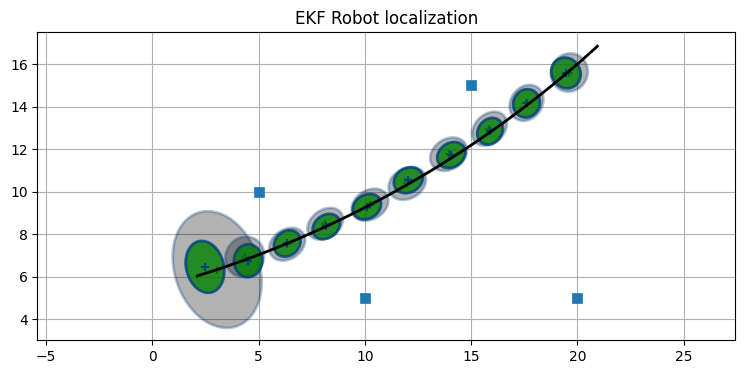

Final P: [0.014 0.016 0.002]


In [24]:
landmarks = array([[5, 10], [10, 5], [15, 15], [20, 5]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1)
plt.show()
print('Final P:', ekf.P.diagonal())

在轨迹末端附近的估计不确定性更小了。通过仅使用前两个地标，我们可以看到多个地标对我们的不确定性产生的影响。

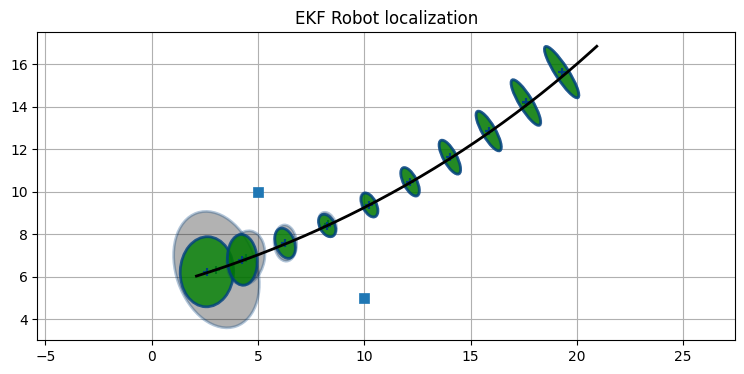

Final P: [0.021 0.045 0.   ]


In [25]:
ekf = run_localization(
    landmarks[0:2], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

在经过地标后，估计迅速偏离了机器人的路径，协方差也迅速增长。让我们看看只使用一个地标会发生什么：

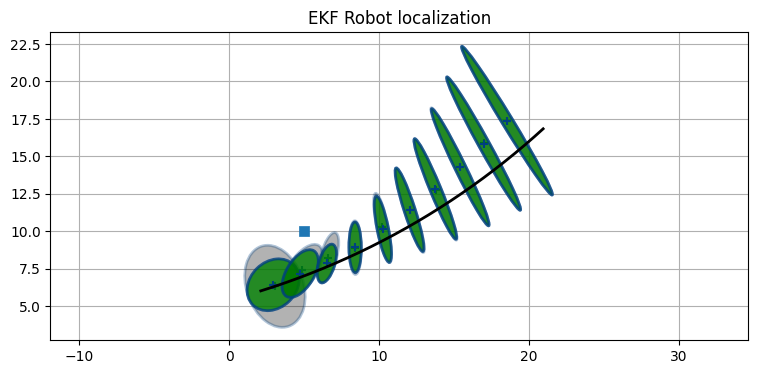

Final P: [0.306 0.752 0.004]


In [26]:
ekf = run_localization(
    landmarks[0:1], std_vel=1.e-10, std_steer=1.e-10,
    std_range=1.4, std_bearing=.05)
print('Final P:', ekf.P.diagonal())

正如你可能猜到的那样，只用一个地标会产生非常糟糕的结果。相反，大量的地标可以让我们做出非常精确的估计。

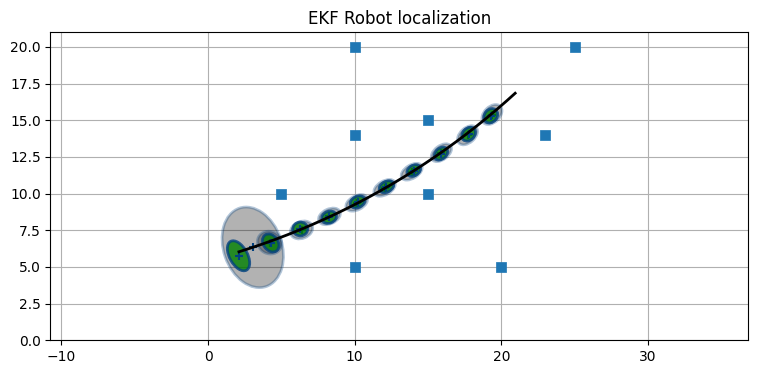

Final P: [0.006 0.007 0.001]


In [27]:
landmarks = array([[5, 10], [10,  5], [15, 15], [20,  5], [15, 10], 
                   [10,14], [23, 14], [25, 20], [10, 20]])

ekf = run_localization(
    landmarks, std_vel=0.1, std_steer=np.radians(1),
    std_range=0.3, std_bearing=0.1, ylim=(0, 21))
print('Final P:', ekf.P.diagonal())

# 讨论

我说这是一个实际问题，在某些方面确实是。我见过一些替代方案，使用了导致简化雅可比矩阵的机器人运动模型。另一方面，我的运动模型在几个方面也很简单化。首先，它使用了自行车模型。真正的汽车有两组车轮，每组都在不同半径上运动。车轮不能完全牢固地附着在地面上。我还假设机器人对控制输入做出即时响应。Sebastian Thrun 在《Probabilistic Robots》中写道，这种简化模型是有道理的，因为当用于跟踪真实车辆时，滤波器的表现良好。这里的教训是，虽然你必须有一个相当准确的非线性模型，但它并不需要完美才能表现良好。作为设计者，你需要在模型的准确度、数学难度以及执行线性代数所需的 CPU 时间之间取得平衡。

这个问题的另一个简化之处在于，我们假设我们知道地标和测量之间的对应关系。但是假设我们使用雷达——我们怎么知道特定的信号返回对应于局部场景中的特定建筑物？这个问题暗示了SLAM算法——同时定位与地图构建。SLAM并不是本书的重点，所以我不会详细展开这个话题。

# UKF vs EKF

在上一章中，我使用了UKF来解决这个问题。两者在实现上的差异应该非常明显。计算状态模型和测量模型的雅可比矩阵并不容易，尽管运动模型很基础。不同的问题可能导致难以或不可能解析推导出雅可比矩阵。相比之下，UKF只需要你提供一个计算系统运动模型的函数和另一个计算测量模型的函数。

有许多情况下雅可比矩阵无法解析求出。细节超出了本书的范围，但你将不得不使用数值方法来计算雅可比矩阵。这项任务并不简单，你在STEM学校攻读硕士学位时将花费大量时间学习处理这种情况的技术。即便如此，你可能只能解决与你领域相关的问题——航空工程师会学到很多关于Navier Stokes方程的知识，但对于建模化学反应速率的知识可能了解不多。

因此，UKF相对容易。它们准确吗？在实践中，它们通常表现比EKF更好。你可以找到很多研究论文证明UKF在各种问题领域中表现优于EKF。为什么UKF表现更好并不难理解。EKF通过在单个点线性化系统模型和测量模型，而UKF使用$2n+1$个点。

让我们看一个具体的例子。取$f(x) = x^3$，并通过一个高斯分布。我将使用蒙特卡洛模拟计算一个精确答案。我随机生成50,000个点，这些点遵循高斯分布，将每个点通过$f(x)$，然后计算结果的均值和方差。

EKF通过求导在评估点$x$找到斜率来线性化函数。这个斜率成为我们用来转换高斯分布的线性函数。这是一个这样的绘图。

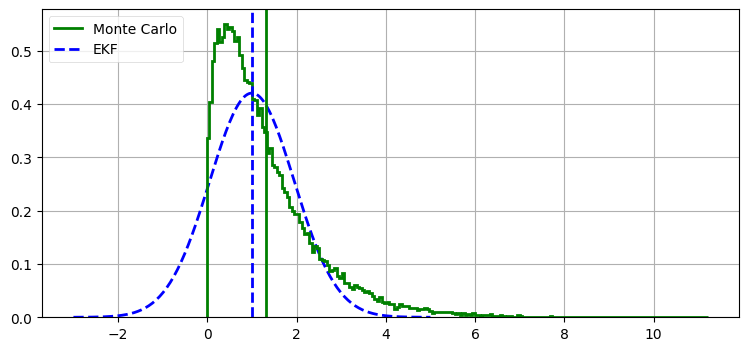

actual mean=1.31, std=1.14
EKF    mean=1.00, std=0.95


In [29]:
import kf_book.nonlinear_plots as nonlinear_plots
nonlinear_plots.plot_ekf_vs_mc()

EKF计算结果相当不准确。相比之下，这是UKF的性能表现：

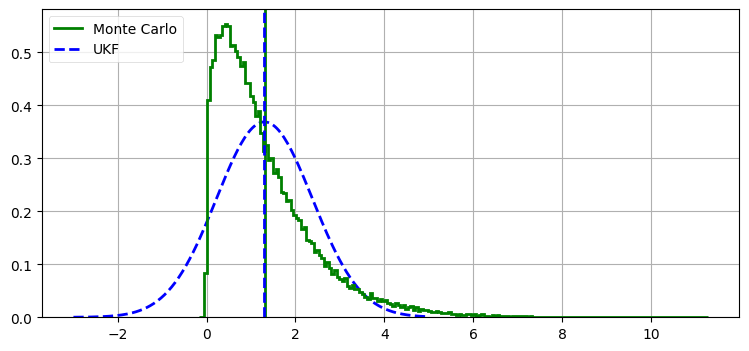

actual mean=1.31, std=1.14
UKF    mean=1.30, std=1.08


In [31]:
nonlinear_plots.plot_ukf_vs_mc(alpha=0.001, beta=3., kappa=1.)

这里可以看到UKF的均值计算精确到小数点后两位。标准差略有偏差，但你也可以通过调整生成sigma点的$\alpha$、$\beta$和$\gamma$参数来微调UKF计算分布的方式。这里我使用了$\alpha=0.001$、$\beta=3$和$\gamma=1$。随意修改它们以查看结果。你应该能够比我得到更好的结果。但是，避免过度调整UKF以适应特定测试。它可能在你的测试案例中表现更好，但在一般情况下可能表现更差。